# Transfer Learning(전이 학습)

In [4]:
# cats_and_dogs classification model with InceptionV3
# train : 2000 images [cat(1000) + dog(1000)]  , size는 다름
# validation : 1000 images [cat(500) + dog(500)] , size는 다름

In [5]:
import tensorflow as tf
import urllib
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras import layers
from tensorflow.keras import Model

In [6]:
# Google InceptionV3 pretrained model 가중치 다운로드, Windows용
_INCEPTION_URL = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
urllib.request.urlretrieve(_INCEPTION_URL, 'tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

('tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
 <http.client.HTTPMessage at 0x1fb3f6e2290>)

In [16]:
# 사전 훈련된 가중치 불러오기
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = 'tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=(150,150,3),
                                include_top = False,
                                weights = None)
pre_trained_model.load_weights(local_weights_file)

# 사전 훈련 계층의 가중치의 훈련(학습) 가능 여부를 설정 : False(학습 안함)
for layer in pre_trained_model.layers:
    layer.trainable = False
pre_trained_model.summary()

# 마지막 층 출력 확인하기
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape : ',last_layer.output_shape)       #(None, 7, 7, 768)
last_output = last_layer.output

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_752 (Conv2D)            (None, 74, 74, 32)   864         ['input_9[0][0]']                
                                                                                                  
 batch_normalization_752 (Batch  (None, 74, 74, 32)  96          ['conv2d_752[0][0]']             
 Normalization)                                                                                   
                                                                                       

In [11]:
len(pre_trained_model.layers)     # 311

311

In [13]:
last_layer = pre_trained_model.get_layer('mixed7')
last_layer

In [17]:
last_output

<KerasTensor: shape=(None, 7, 7, 768) dtype=float32 (created by layer 'mixed7')>

In [25]:
# 모델구성/컴파일
# Flatten Layer
x = layers.Flatten()(last_output)
# Dense Layer : Hidden Layer
x = layers.Dense(1024,activation='relu')(x) # (None,1024)
#Dropout layer
x = layers.Dropout(0.2)(x)
# Dense Layer : Final output Layer
x = layers.Dense(1,activation='sigmoid')(x)

model = Model(pre_trained_model.input,x)

model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics =['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_752 (Conv2D)            (None, 74, 74, 32)   864         ['input_9[0][0]']                
                                                                                                  
 batch_normalization_752 (Batch  (None, 74, 74, 32)  96          ['conv2d_752[0][0]']             
 Normalization)                                                                                   
                                                                                            

In [26]:
train_dir = 'tmp/cats_and_dogs_filtered/train'
validation_dir = 'tmp/cats_and_dogs_filtered/validation'

# 이미지 데이터 경로 설정
import os

base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

In [27]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [28]:
# 학습
# 사전 훈련 가중치는 업데이트 하지 않고 추가 계층만 가중치 업데이트하여 학습
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 1)

Epoch 1/20
100/100 [==============================] - 22s 171ms/step - loss: 0.3533 - accuracy: 0.8535 - val_loss: 0.1427 - val_accuracy: 0.9410
Epoch 2/20
100/100 [==============================] - 8s 84ms/step - loss: 0.2278 - accuracy: 0.9120 - val_loss: 0.0831 - val_accuracy: 0.9620
Epoch 3/20
100/100 [==============================] - 8s 84ms/step - loss: 0.1974 - accuracy: 0.9280 - val_loss: 0.1003 - val_accuracy: 0.9620
Epoch 4/20
100/100 [==============================] - 9s 85ms/step - loss: 0.1999 - accuracy: 0.9250 - val_loss: 0.1891 - val_accuracy: 0.9400
Epoch 5/20
100/100 [==============================] - 8s 85ms/step - loss: 0.1861 - accuracy: 0.9360 - val_loss: 0.1188 - val_accuracy: 0.9630
Epoch 6/20
100/100 [==============================] - 9s 85ms/step - loss: 0.1798 - accuracy: 0.9290 - val_loss: 0.1126 - val_accuracy: 0.9630
Epoch 7/20
100/100 [==============================] - 9s 85ms/step - loss: 0.1583 - accuracy: 0.9420 - val_loss: 0.2171 - val_accuracy: 0.94

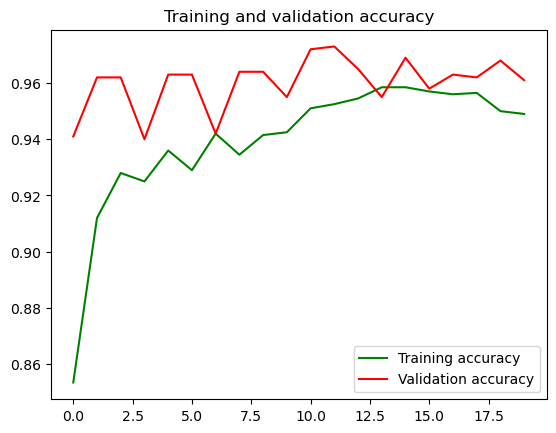

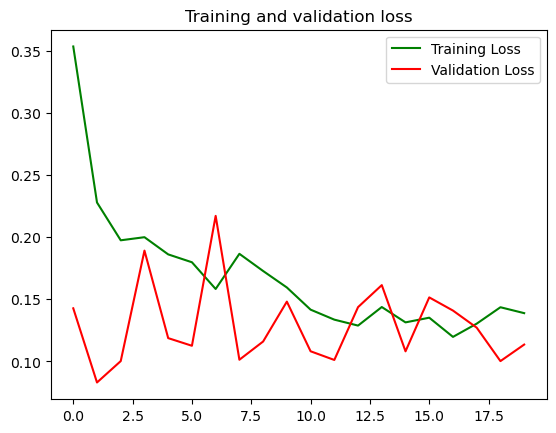

In [29]:
import matplotlib.pyplot as plt
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()